In [ ]:
pip install sktime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.5/35.5 MB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.7/145.7 kB 16.8 MB/s eta 0:00:00


#Required Imports

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sktime.datasets import load_from_tsfile_to_dataframe
from sklearn.preprocessing import label_binarize
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score
import itertools, time, os, json, gc
from keras import layers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from scipy import signal
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve


#Loading the datasets using sktime lib

In [ ]:

# Load training and test data
X_train, y_train = load_from_tsfile_to_dataframe("ECG200_TRAIN.ts")
X_test, y_test = load_from_tsfile_to_dataframe("ECG200_TEST.ts")


#Checking the data values

In [ ]:
print(X_train.shape)
print(X_train.head())
print(y_train)

(100, 1)
                                               dim_0
0  0     0.502055
1     0.542163
2     0.722383
3...
1  0     0.147647
1     0.804668
2     0.367771
3...
2  0     0.316646
1     0.243199
2     0.370471
3...
3  0     1.168874
1     2.075901
2     1.760141
3...
4  0     0.648658
1     0.752026
2     2.636231
3...
['-1' '1' '-1' '-1' '1' '1' '-1' '-1' '1' '1' '1' '1' '1' '1' '-1' '1' '1'
 '1' '-1' '-1' '1' '1' '1' '-1' '1' '1' '1' '-1' '1' '1' '1' '1' '1' '1'
 '1' '-1' '1' '1' '1' '1' '1' '1' '1' '-1' '-1' '1' '-1' '-1' '1' '-1' '1'
 '1' '1' '-1' '1' '1' '-1' '-1' '1' '1' '1' '-1' '1' '1' '1' '-1' '1' '1'
 '1' '1' '1' '1' '-1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '-1' '-1'
 '-1' '-1' '1' '-1' '1' '-1' '1' '1' '-1' '1' '1' '-1' '-1' '1' '1']


#Checking if the data contains any missing values

In [ ]:
#Missing values check

print("Missing values for x-train")
print(X_train.isnull().sum())

missing_values_num = (y_train == '') | (y_train == None)
miss_total = missing_values_num.sum()

print(f"Total no of missing labels in y-train: {miss_total}")



Missing values for x-train
dim_0    0
dtype: int64
Total no of missing labels in y-train: 0


#Visualizing how many samples are present in each class



/tmp/ipython-input-1619007563.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, palette="viridis", order=unique_labels)


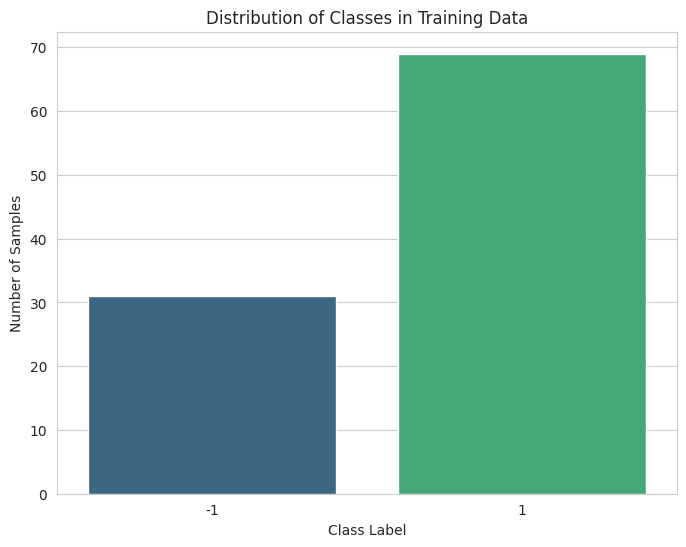

In [ ]:
# Converting X_train DataFrame to a 2D numpy array
X_train_arr = np.array(X_train['dim_0'].tolist())
unique_labels = np.unique(y_train)

# Setting a style for plot
sns.set_style("whitegrid")

# Plotting Bar Chart to understand the class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train, palette="viridis", order=unique_labels)
plt.title('Distribution of Classes in Training Data')
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.show()

#Frequency-Domain Analysis Plot

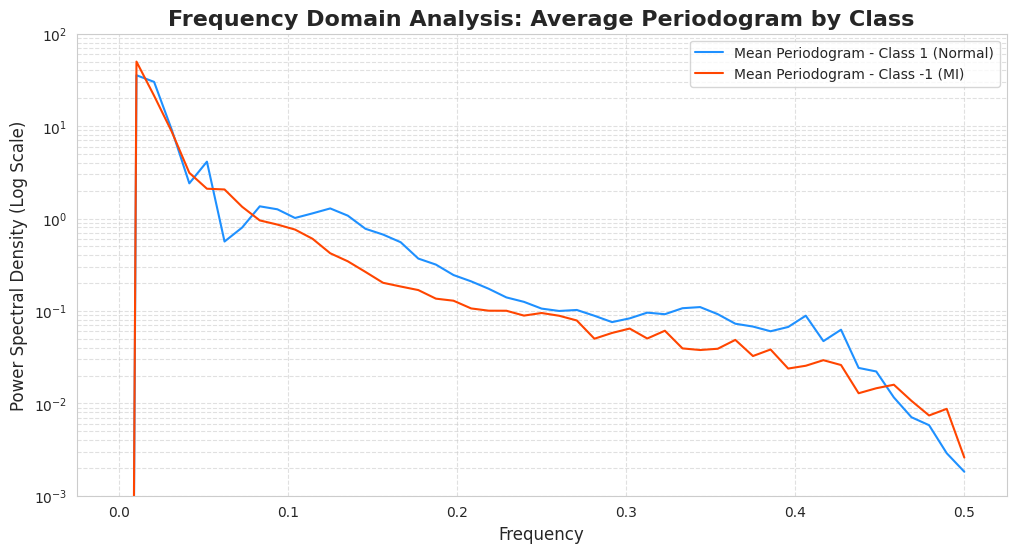

In [ ]:

X_train_np = np.stack(X_train['dim_0'].values)
y_train_int = y_train.astype(int)

# Separate the data by class
class_pos1_data = X_train_np[y_train_int == 1]
class_neg1_data = X_train_np[y_train_int == -1]

# Calculating average periodogram for Class 1
freqs_1, Pxx_pos1 = signal.periodogram(class_pos1_data, axis=1)
mean_Pxx_pos1 = np.mean(Pxx_pos1, axis=0)

# Calculate average periodogram for Class -1
freqs_neg1, Pxx_neg1 = signal.periodogram(class_neg1_data, axis=1)
mean_Pxx_neg1 = np.mean(Pxx_neg1, axis=0)

# Plotting the graph
plt.figure(figsize=(12, 6))
plt.semilogy(freqs_1, mean_Pxx_pos1, label='Mean Periodogram - Class 1 (Normal)', color='dodgerblue')
plt.semilogy(freqs_neg1, mean_Pxx_neg1, label='Mean Periodogram - Class -1 (MI)', color='orangered')

plt.title('Frequency Domain Analysis: Average Periodogram by Class', fontsize=16, weight='bold')
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Power Spectral Density (Log Scale)', fontsize=12)
plt.ylim(1e-3, 1e2)
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.show()

#Plotting samples from each class

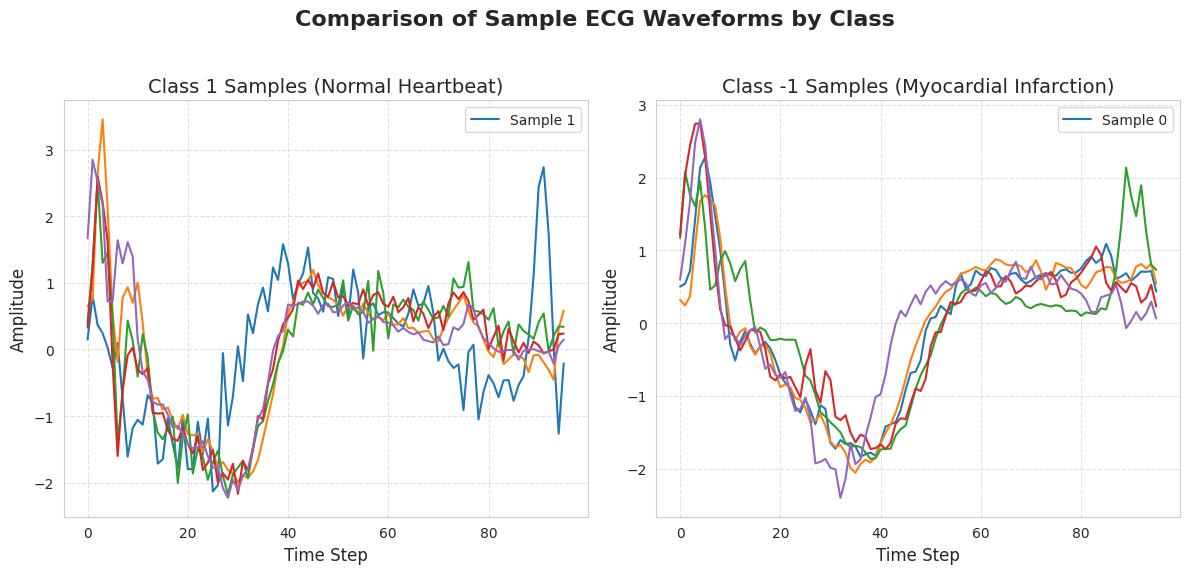

In [ ]:


# Converting DataFrame into a 2D NumPy array
X_train_np = np.stack(X_train['dim_0'].values)

# Convert string labels to integers
y_train_int = y_train.astype(int)

plt.figure(figsize=(12, 6))

# Number of samples to be plotted from each class
n_samples_to_plot = 5

# Plotting samples for Class 1
plt.subplot(1, 2, 1)
# Getting indices for class 1
class_pos1_indices = np.where(y_train_int == 1)[0][:n_samples_to_plot]
for i in class_pos1_indices:
    plt.plot(X_train_np[i], label=f'Sample {i}' if i == class_pos1_indices[0] else "")
plt.title('Class 1 Samples (Normal Heartbeat)', fontsize=14)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Amplitude', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)


# Plotting samples for Class -1
plt.subplot(1, 2, 2)
# Getting indices for class -1
class_neg1_indices = np.where(y_train_int == -1)[0][:n_samples_to_plot]
for i in class_neg1_indices:
    plt.plot(X_train_np[i], label=f'Sample {i}' if i == class_neg1_indices[0] else "")
plt.title('Class -1 Samples (Myocardial Infarction)', fontsize=14)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Amplitude', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.suptitle('Comparison of Sample ECG Waveforms by Class', fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#Average ECG Waveform Plot

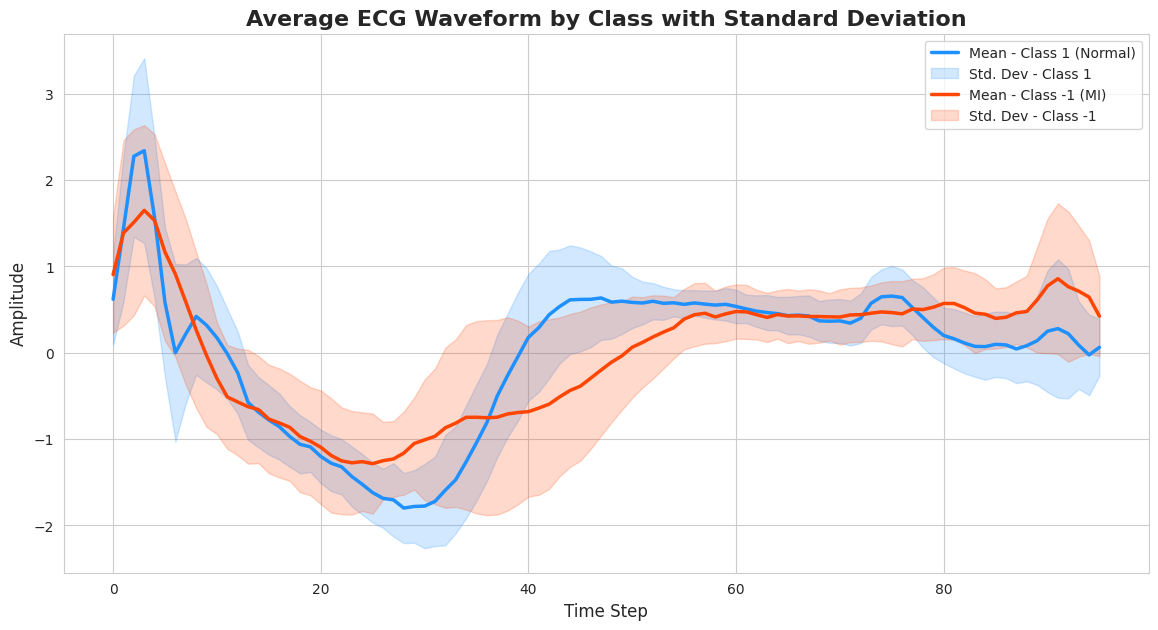

In [ ]:
X_train_np = np.stack(X_train['dim_0'].values)
y_train_int = y_train.astype(int)

# Separating data by classes
class_pos1_data = X_train_np[y_train_int == 1]
class_neg1_data = X_train_np[y_train_int == -1]

# Calculating mean and standard deviation for both classes
mean_class_pos1 = class_pos1_data.mean(axis=0)
std_class_pos1 = class_pos1_data.std(axis=0)

mean_class_neg1 = class_neg1_data.mean(axis=0)
std_class_neg1 = class_neg1_data.std(axis=0)

# Time axis
time_steps = np.arange(X_train_np.shape[1])

plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")

# Plotting Class 1
plt.plot(time_steps, mean_class_pos1, label='Mean - Class 1 (Normal)', color='dodgerblue', linewidth=2.5)
plt.fill_between(time_steps, mean_class_pos1 - std_class_pos1, mean_class_pos1 + std_class_pos1, color='dodgerblue', alpha=0.2, label='Std. Dev - Class 1')

# Ploting Class -1
plt.plot(time_steps, mean_class_neg1, label='Mean - Class -1 (MI)', color='orangered', linewidth=2.5)
plt.fill_between(time_steps, mean_class_neg1 - std_class_neg1, mean_class_neg1 + std_class_neg1, color='orangered', alpha=0.2, label='Std. Dev - Class -1')

plt.title('Average ECG Waveform by Class with Standard Deviation', fontsize=16, weight='bold')
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Amplitude', fontsize=12)
plt.legend(loc='upper right')
plt.show()

#Box Plots for diff statistics of each class

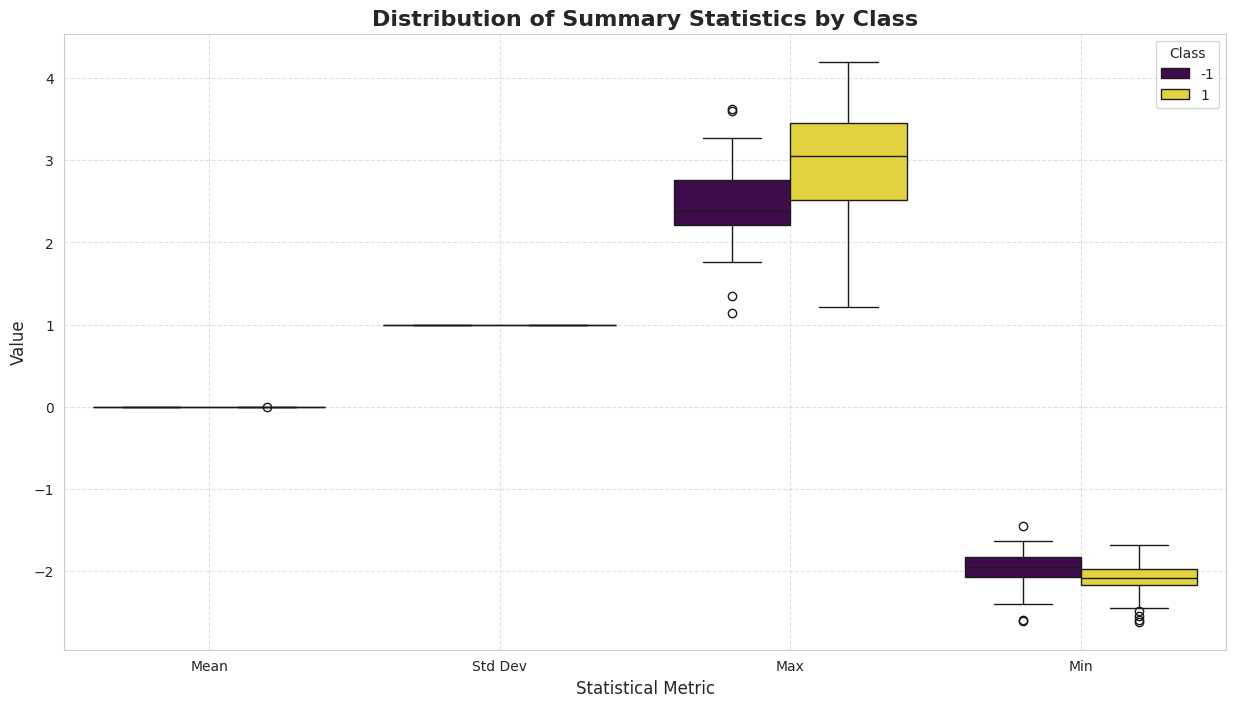

In [ ]:

# Converting DataFrame into a 2D NumPy array
X_train_np = np.stack(X_train['dim_0'].values)
# Converting string labels to integers
y_train_int = y_train.astype(int)

#DataFrame to hold the summary statistics for each time series
stats_df = pd.DataFrame()
stats_df['Mean'] = np.mean(X_train_np, axis=1)
stats_df['Std Dev'] = np.std(X_train_np, axis=1)
stats_df['Max'] = np.max(X_train_np, axis=1)
stats_df['Min'] = np.min(X_train_np, axis=1)
stats_df['Class'] = y_train_int

melted_stats_df = stats_df.melt(id_vars='Class', var_name='Statistic', value_name='Value')

plt.figure(figsize=(15, 8))
sns.boxplot(x='Statistic', y='Value', hue='Class', data=melted_stats_df, palette='viridis')
plt.title('Distribution of Summary Statistics by Class', fontsize=16, weight='bold')
plt.xlabel('Statistical Metric', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Class', loc='upper right')
plt.show()

#**1-D CNN Model for ECG200**

Label mapping: {np.str_('-1'): np.int64(0), np.str_('1'): np.int64(1)}
Class weights: {0: 1.6, 1: 0.7272727272727273}

--- Run 1 | E=100, LR=0.1, B=8 ---
Test @ t=1.000 -> Acc=0.8300, P=0.8406, R=0.9062, F1=0.8722
Saved best CNN to: best_ecg200_cnn.keras and metadata to best_ecg200_cnn_meta.json

--- Run 2 | E=100, LR=0.1, B=16 ---
Test @ t=1.000 -> Acc=0.8500, P=0.9298, R=0.8281, F1=0.8760
Saved best CNN to: best_ecg200_cnn.keras and metadata to best_ecg200_cnn_meta.json

--- Run 3 | E=100, LR=0.1, B=32 ---
Test @ t=1.000 -> Acc=0.8300, P=0.8730, R=0.8594, F1=0.8661

--- Run 4 | E=100, LR=0.01, B=8 ---
Test @ t=0.999 -> Acc=0.8400, P=0.9800, R=0.7656, F1=0.8596

--- Run 5 | E=100, LR=0.01, B=16 ---
Test @ t=1.000 -> Acc=0.8500, P=0.9804, R=0.7812, F1=0.8696

--- Run 6 | E=100, LR=0.01, B=32 ---
Test @ t=0.949 -> Acc=0.8000, P=0.9783, R=0.7031, F1=0.8182

--- Run 7 | E=100, LR=0.001, B=8 ---
Test @ t=0.997 -> Acc=0.8100, P=0.9787, R=0.7188, F1=0.8288

--- Run 8 | E=100, LR=0.001, B=16 

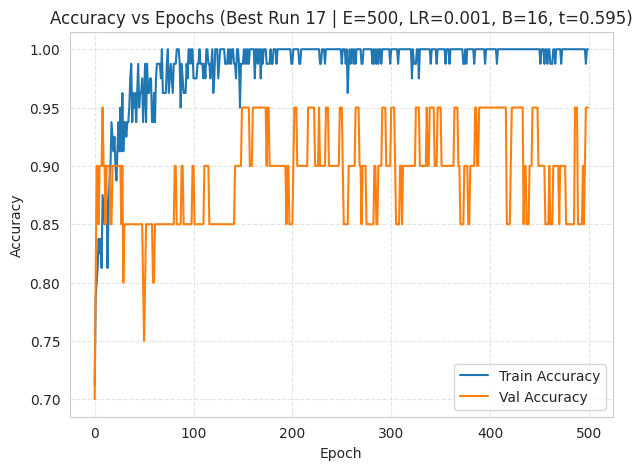

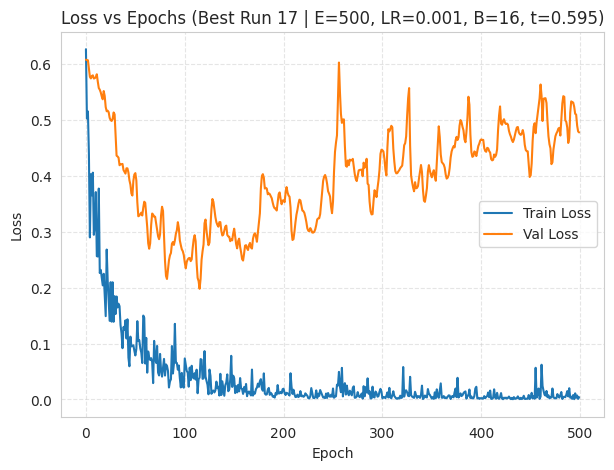

In [ ]:

# Applying seed for reproducability
tf.keras.utils.set_random_seed(42)

# Pre-processing Dataset
def convert_sktime_to_numpy(X):
    return np.array([series.values for series in X.iloc[:, 0]], dtype=np.float32)

def z_score_per_sample_1d(X_2d):
    mean = X_2d.mean(axis=1, keepdims=True)
    std  = X_2d.std(axis=1, keepdims=True)
    std  = np.where(std == 0, 1.0, std)
    return (X_2d - mean) / std

def plot_training_curves_inline(history, title_suffix=""):
    h = history.history
    h_acc = h.get('accuracy', h.get('acc'))
    h_val_acc = h.get('val_accuracy', h.get('val_acc'))
    h_loss = h.get('loss'); h_val_loss = h.get('val_loss')
    if h_acc is not None and h_val_acc is not None:
        plt.figure(figsize=(7,5))
        plt.plot(h_acc, label='Train Accuracy'); plt.plot(h_val_acc, label='Val Accuracy')
        plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title(f'Accuracy vs Epochs {title_suffix}')
        plt.legend(); plt.grid(True, linestyle='--', alpha=0.5); plt.show()
    if h_loss is not None and h_val_loss is not None:
        plt.figure(figsize=(7,5))
        plt.plot(h_loss, label='Train Loss'); plt.plot(h_val_loss, label='Val Loss')
        plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title(f'Loss vs Epochs {title_suffix}')
        plt.legend(); plt.grid(True, linestyle='--', alpha=0.5); plt.show()

def pick_threshold_roc(y_true, probs):
    fpr, tpr, thresholds = roc_curve(y_true, probs)
    j_scores = tpr - fpr
    best_idx = np.argmax(j_scores)
    return thresholds[best_idx]


X_train_arr = z_score_per_sample_1d(convert_sktime_to_numpy(X_train))
X_test_arr  = z_score_per_sample_1d(convert_sktime_to_numpy(X_test))

X_train_re = X_train_arr[:, :, None]
X_test_re  = X_test_arr[:, :, None]

le = LabelEncoder()
encoded_y_train = le.fit_transform(np.asarray(y_train))
encoded_y_test  = le.transform(np.asarray(y_test))

print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

classes, counts = np.unique(encoded_y_train, return_counts=True)
positive_label = classes[np.argmax(counts)]

# Applyiong Validation Split
stratsplit = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
(train_idx, val_idx), = stratsplit.split(X_train_re, encoded_y_train)
X_trn, y_trn = X_train_re[train_idx], encoded_y_train[train_idx]
X_val, y_val = X_train_re[val_idx], encoded_y_train[val_idx]

# Added class weights to handle imbalance
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_trn), y=y_trn)
class_weigh_dict = dict(zip(np.unique(y_trn), class_weights))
print("Class weights:", {int(k): float(v) for k,v in class_weigh_dict.items()})

# Hyperparameter Grid
epochs_list = [100, 500, 1000]
learning_rates_list = [0.1, 0.01, 0.001]
batch_sizes_list = [8, 16, 32]

best_cnn_f1 = -1.0
best_cnn_info = {}
best_cnn_model = None
best_cnn_history = None
rows = []
run = 0
best_cnn_path = "best_ecg200_cnn.keras"

for e in epochs_list:
    for lr in learning_rates_list:
        for bs in batch_sizes_list:
            run += 1
            print(f"\n--- Run {run} | E={e}, LR={lr}, B={bs} ---")

            model = tf.keras.Sequential([
                tf.keras.layers.Input(shape=(X_trn.shape[1], 1)),
                tf.keras.layers.GaussianNoise(0.1),

                tf.keras.layers.Conv1D(64, kernel_size=7, activation='relu'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dropout(0.2),
                tf.keras.layers.MaxPooling1D(pool_size=2),

                tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dropout(0.2),
                tf.keras.layers.MaxPooling1D(pool_size=2),

                tf.keras.layers.Flatten(),
                tf.keras.layers.Dropout(0.3),
                tf.keras.layers.Dense(1, activation='sigmoid')
            ])

            model.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                loss='binary_crossentropy',
                metrics=['accuracy']
            )

            history = model.fit(
                X_trn, y_trn,
                epochs=e, batch_size=bs, verbose=0,
                validation_data=(X_val, y_val),
                class_weight=class_weigh_dict
            )

            # Selecting Threshold
            val_probs = model.predict(X_val, verbose=0).ravel()
            y_val_pos = (y_val == positive_label).astype(int)
            best_thresh = pick_threshold_roc(y_val_pos, val_probs)

            # Evaluating the model
            test_probs = model.predict(X_test_re, verbose=0).ravel()
            y_true_pos = (encoded_y_test == positive_label).astype(int)
            y_pred_pos = (test_probs >= best_thresh).astype(int)

            cnn_acc  = accuracy_score(y_true_pos, y_pred_pos)
            cnn_prec = precision_score(y_true_pos, y_pred_pos, zero_division=0)
            cnn_rec  = recall_score(y_true_pos, y_pred_pos, zero_division=0)
            cnn_f1   = f1_score(y_true_pos, y_pred_pos, zero_division=0)

            rows.append({
                "Run": run, "Epochs": e, "LR": lr, "Batch": bs,
                "Thresh": round(best_thresh, 4),
                "Accuracy": cnn_acc, "Precision": cnn_prec, "Recall": cnn_rec, "F1": cnn_f1
            })
            print(f"Test @ t={best_thresh:.3f} -> Acc={cnn_acc:.4f}, P={cnn_prec:.4f}, R={cnn_rec:.4f}, F1={cnn_f1:.4f}")

            # === Save Best ===
            if cnn_f1 > best_cnn_f1:
                best_cnn_f1 = cnn_f1
                best_cnn_model = model
                best_cnn_history = history
                best_cnn_info = {
                    "Run": run, "Epochs": e, "LR": lr, "Batch": bs,
                    "Thresh": float(best_thresh), "Accuracy": float(cnn_acc),
                    "Precision": float(cnn_prec), "Recall": float(cnn_rec), "F1": float(cnn_f1)
                }

                best_cnn_model.save(best_cnn_path)
                np.save("y_true_ecg.npy", y_true_pos)
                np.save("y_prob_ecg_cnn.npy", test_probs)
                with open("best_ecg200_cnn_meta.json", "w") as f:
                    json.dump(best_cnn_info, f, indent=2)
                print(f"Saved best CNN to: {best_cnn_path} and metadata to best_ecg200_cnn_meta.json")

# Displaying Results
df = pd.DataFrame(rows).sort_values("Run").reset_index(drop=True)
print("\nAll run results:")
print(df)

print("\nBest model (by F1):")
print({k: (round(v,4) if isinstance(v, float) else v) for k,v in best_cnn_info.items()})

summary = df[["Accuracy","Precision","Recall","F1"]].agg(['mean','std'])
print("\nSummary across runs (Mean ± Std):")
print(summary)
for metric in ["Accuracy","Precision","Recall","F1"]:
    m, s = summary.loc['mean', metric], summary.loc['std', metric]
    print(f"{metric}: {m:.4f} ± {s:.4f}")

# Plotting curve for best run
if best_cnn_history is not None:
    plot_training_curves_inline(
        best_cnn_history,
        title_suffix=(f"(Best Run {best_cnn_info['Run']} | "
                      f"E={best_cnn_info['Epochs']}, LR={best_cnn_info['LR']}, "
                      f"B={best_cnn_info['Batch']}, t={best_cnn_info['Thresh']:.3f})")
    )


#**Transformer Model**

Class weights (train split): {0: 1.6, 1: 0.7272727272727273}
Run 01 | E=100  LR=0.1 B=8  -> Acc=0.3600  P=0.3600  R=1.0000  F1=0.5294
Saved best Transformer to: saved_models/best_ecg200_transformer.keras
Run 02 | E=100  LR=0.1 B=16 -> Acc=0.3600  P=0.3600  R=1.0000  F1=0.5294
Run 03 | E=100  LR=0.1 B=32 -> Acc=0.3600  P=0.3600  R=1.0000  F1=0.5294
Run 04 | E=100  LR=0.01 B=8  -> Acc=0.3400  P=0.3438  R=0.9167  F1=0.5000
Run 05 | E=100  LR=0.01 B=16 -> Acc=0.3700  P=0.3548  R=0.9167  F1=0.5116
Run 06 | E=100  LR=0.01 B=32 -> Acc=0.6500  P=0.5455  R=0.1667  F1=0.2553
Run 07 | E=100  LR=0.001 B=8  -> Acc=0.8000  P=0.9000  R=0.5000  F1=0.6429
Saved best Transformer to: saved_models/best_ecg200_transformer.keras
Run 08 | E=100  LR=0.001 B=16 -> Acc=0.8700  P=0.8966  R=0.7222  F1=0.8000
Saved best Transformer to: saved_models/best_ecg200_transformer.keras
Run 09 | E=100  LR=0.001 B=32 -> Acc=0.8600  P=0.7500  R=0.9167  F1=0.8250
Saved best Transformer to: saved_models/best_ecg200_transformer

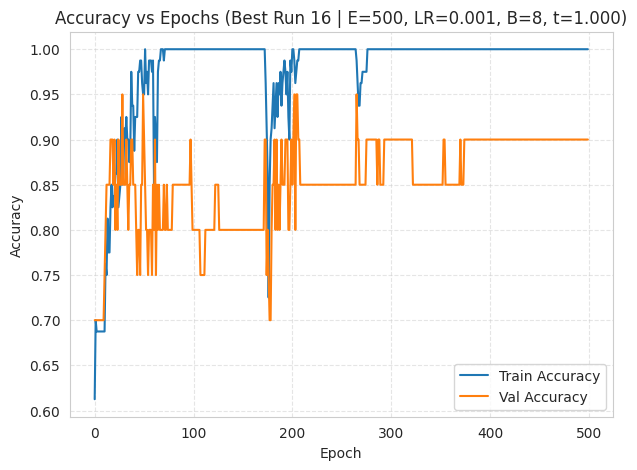

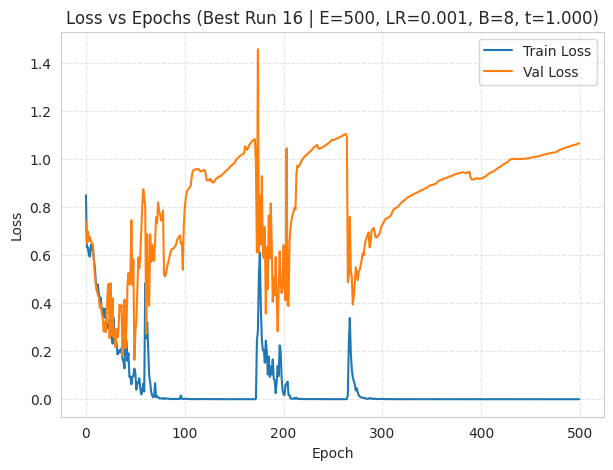

In [ ]:


# Applying seed for reproducibility
tf.keras.utils.set_random_seed(42)
os.makedirs("saved_models", exist_ok=True)

#Functions to pre-process the dataset
def sktime_nested_to_3d(X_nested: pd.DataFrame) -> np.ndarray:
    n_samples, n_channels = X_nested.shape
    seq_len = len(X_nested.iloc[0, 0])
    out = np.empty((n_samples, seq_len, n_channels), dtype=np.float32)
    for i in range(n_samples):
        for c in range(n_channels):
            out[i, :, c] = np.asarray(X_nested.iat[i, c], dtype=np.float32)
    return out

def instance_zscore(X: np.ndarray, eps: float = 1e-8) -> np.ndarray:
    mean = X.mean(axis=1, keepdims=True)
    std  = X.std(axis=1, keepdims=True)
    return (X - mean) / (std + eps)

def plot_training_curves_inline(history, title_suffix=""):
    h = history.history
    h_acc = h.get('accuracy', h.get('acc'))
    h_val_acc = h.get('val_accuracy', h.get('val_acc'))
    h_loss = h.get('loss'); h_val_loss = h.get('val_loss')

    if h_acc is not None and h_val_acc is not None:
        plt.figure(figsize=(7,5))
        plt.plot(h_acc, label='Train Accuracy'); plt.plot(h_val_acc, label='Val Accuracy')
        plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title(f'Accuracy vs Epochs {title_suffix}')
        plt.legend(); plt.grid(True, linestyle='--', alpha=0.5); plt.show()

    if h_loss is not None and h_val_loss is not None:
        plt.figure(figsize=(7,5))
        plt.plot(h_loss, label='Train Loss'); plt.plot(h_val_loss, label='Val Loss')
        plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title(f'Loss vs Epochs {title_suffix}')
        plt.legend(); plt.grid(True, linestyle='--', alpha=0.5); plt.show()


X_train_np = sktime_nested_to_3d(X_train).astype("float32")
X_test_np  = sktime_nested_to_3d(X_test).astype("float32")

X_train_np = instance_zscore(X_train_np)
X_test_np  = instance_zscore(X_test_np)

seq_len, n_channels = X_train_np.shape[1], X_train_np.shape[2]

# Encoding labels
le = LabelEncoder()
y_train_idx = le.fit_transform(np.asarray(y_train))
y_test_idx  = le.transform(np.asarray(y_test))

classes, counts = np.unique(y_train_idx, return_counts=True)
minority_label = classes[np.argmin(counts)]

y_train_arr = (y_train_idx == minority_label).astype("float32").reshape(-1, 1)
y_test_arr       = (y_test_idx  == minority_label).astype("float32").reshape(-1, 1)

#Applying stratified splits
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
(train_idx, val_idx), = strat_split.split(X_train_np, y_train_idx)

X_trn, y_trn_idx = X_train_np[train_idx], y_train_idx[train_idx]
X_val, y_val_idx = X_train_np[val_idx],  y_train_idx[val_idx]

y_trn_bin = (y_trn_idx == minority_label).astype("float32").reshape(-1,1)
y_val_bin = (y_val_idx == minority_label).astype("float32").reshape(-1,1)

# Applying class weights to handle the imbalance
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_trn_idx), y=y_trn_idx)
class_weights_dict = {int(k): float(v) for k, v in zip(np.unique(y_trn_idx), class_weights)}
print("Class weights (train split):", class_weights_dict)

#Applying sinusoidal positional encoding
class SinusoidalPositionalEncoding(layers.Layer):
    def __init__(self, d_model, **kwargs):
        super().__init__(**kwargs)
        self.d_model = d_model

    def call(self, x):

        T = tf.shape(x)[1]
        pos = tf.range(T, dtype=tf.float32)[:, None]
        i = tf.range(self.d_model, dtype=tf.float32)[None, :]
        angles = pos / tf.pow(10000.0, (2.0 * tf.floor(i/2.0)) / self.d_model)
        pe = tf.where(tf.cast(i % 2, tf.bool), tf.cos(angles), tf.sin(angles))
        return x + pe[None, :, :]

#Transformer Model Building
def transformer_block(inputs, head_size=32, num_heads=2, ff_dim=128, dropout=0.1):
    x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x + inputs)
    y = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    y = layers.Dropout(dropout)(y)
    y = layers.Conv1D(filters=x.shape[-1], kernel_size=1)(y)
    y = layers.LayerNormalization(epsilon=1e-6)(y + x)
    return y

def build_ts_transformer_binary(
    seq_len, n_channels,
    d_model=64, head_size=32, num_heads=2, ff_dim=128,
    num_transformer_blocks=2, dropout=0.1,
    mlp_units=(64,), mlp_dropout=0.1,
    learning_rate=1e-3
):
    inputs = layers.Input(shape=(seq_len, n_channels))
    x = layers.Conv1D(filters=d_model, kernel_size=1, padding="same")(inputs)
    x = SinusoidalPositionalEncoding(d_model=d_model)(x)
    for _ in range(num_transformer_blocks):
        x = transformer_block(x, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout)
    x = layers.GlobalAveragePooling1D()(x)
    for u in (mlp_units if isinstance(mlp_units, (list,tuple)) else [mlp_units]):
        x = layers.Dense(u, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

ARCH = dict(
    d_model=64, head_size=32, num_heads=2, ff_dim=128,
    num_transformer_blocks=2, dropout=0.1,
    mlp_units=(64,), mlp_dropout=0.1
)

# Applying grid search for tuning the hyperparameters
epochs_list = [100, 500, 1000]
lr_list     = [0.1, 0.01, 0.001]
batch_list  = [8, 16, 32]

best_trans_f1 = -1.0
best_trans_info = {}
best_trans_model = None
best_trans_history = None

rows = []
run = 0

best_model_path = "saved_models/best_ecg200_transformer.keras"
best_meta_path  = "saved_models/best_ecg200_transformer_meta.json"

for epochs, lr, batch in itertools.product(epochs_list, lr_list, batch_list):
    run += 1
    keras.backend.clear_session()

    model = build_ts_transformer_binary(
        seq_len=seq_len, n_channels=n_channels,
        learning_rate=lr, **ARCH
    )

    history = model.fit(
        X_trn, y_trn_bin,
        epochs=epochs,
        batch_size=batch,
        validation_data=(X_val, y_val_bin),
        class_weight=class_weights_dict,
        verbose=0
    )

    # Choosing threshold
    val_probs = model.predict(X_val, verbose=0).ravel()
    y_val_pos = y_val_bin.ravel().astype(int)
    p, r, t = precision_recall_curve(y_val_pos, val_probs)
    if t.size == 0:
        best_thresh = 0.5
    else:
        f1s = 2 * (p[:-1] * r[:-1]) / (p[:-1] + r[:-1] + 1e-12)
        best_idx = int(np.nanargmax(f1s))
        best_thresh = float(t[best_idx])

    # Evaluating the model on the basis of diff metrics
    test_probs = model.predict(X_test_np, verbose=0).ravel()
    y_true_pos = y_test_arr.ravel().astype(int)
    y_pred_pos = (test_probs >= best_thresh).astype(int)

    trans_acc  = accuracy_score(y_true_pos, y_pred_pos)
    trans_prec = precision_score(y_true_pos, y_pred_pos, zero_division=0)
    trans_rec  = recall_score(y_true_pos, y_pred_pos, zero_division=0)
    trans_f1   = f1_score(y_true_pos, y_pred_pos, zero_division=0)

    rows.append({
        "Run": run, "Epochs": epochs, "LR": lr, "Batch": batch,
        "Thresh": round(best_thresh, 4),
        "Accuracy": trans_acc, "Precision": trans_prec, "Recall": trans_rec, "F1": trans_f1
    })
    print(f"Run {run:02d} | E={epochs:<4} LR={lr:<.4g} B={batch:<2} -> "
          f"Acc={trans_acc:.4f}  P={trans_prec:.4f}  R={trans_rec:.4f}  F1={trans_f1:.4f}")

    #Choosing the best model on the basis of F1 score
    if trans_f1 > best_trans_f1:
        best_trans_f1 = trans_f1
        best_trans_model = model
        best_trans_history = history
        best_trans_info = {
            "Run": run, "Epochs": epochs, "LR": float(lr), "Batch": int(batch),
            "Thresh": float(best_thresh), "Accuracy": float(trans_acc),
            "Precision": float(trans_prec), "Recall": float(trans_rec), "F1": float(trans_f1)
           }
        np.save("y_prob_ecg_trans.npy", test_probs)


        # Saving the best model and its info
        best_trans_model.save(best_model_path)
        with open(best_meta_path, "w") as f:
            json.dump(best_trans_info, f, indent=2)
        print(f"Saved best Transformer to: {best_model_path}")

#Printing results in a tabular form
df = pd.DataFrame(rows).sort_values("Run").reset_index(drop=True)
print("\nAll run results (ECG200 Transformer, binary):")
print(df)

print("\nBest model (by F1):")
print({k: (round(v,4) if isinstance(v, float) else v) for k, v in best_trans_info.items()})

summary = df[["Accuracy","Precision","Recall","F1"]].agg(['mean','std'])
print("\nSummary across runs (Mean ± Std):")
print(summary)
for metric in ["Accuracy","Precision","Recall","F1"]:
    m, s = summary.loc['mean', metric], summary.loc['std', metric]
    print(f"{metric}: {m:.4f} ± {s:.4f}")

#Plotting accuracy/loss curves
if best_trans_history is not None:
    plot_training_curves_inline(
        best_trans_history,
        title_suffix=(f"(Best Run {best_trans_info['Run']} | "
                      f"E={best_trans_info['Epochs']}, LR={best_trans_info['LR']}, "
                      f"B={best_trans_info['Batch']}, t={best_trans_info['Thresh']:.3f})")
    )


#**Inception Time Model**

Run 01 | E=100  LR=0.01 B=8  -> Acc=0.8800  P=0.8939  R=0.9219  F1=0.9077
Run 02 | E=100  LR=0.01 B=16 -> Acc=0.4800  P=1.0000  R=0.1875  F1=0.3158


Run 03 | E=100  LR=0.01 B=32 -> Acc=0.8300  P=0.9434  R=0.7812  F1=0.8547


Run 04 | E=100  LR=0.001 B=8  -> Acc=0.8600  P=0.8676  R=0.9219  F1=0.8939
Run 05 | E=100  LR=0.001 B=16 -> Acc=0.6900  P=0.6737  R=1.0000  F1=0.8050
Run 06 | E=100  LR=0.001 B=32 -> Acc=0.8400  P=0.8750  R=0.8750  F1=0.8750
Run 07 | E=100  LR=0.1 B=8  -> Acc=0.7800  P=0.7625  R=0.9531  F1=0.8472
Run 08 | E=100  LR=0.1 B=16 -> Acc=0.7100  P=0.8302  R=0.6875  F1=0.7521
Run 09 | E=100  LR=0.1 B=32 -> Acc=0.7700  P=0.8060  R=0.8438  F1=0.8244
Run 10 | E=500  LR=0.01 B=8  -> Acc=0.8600  P=0.8788  R=0.9062  F1=0.8923
Run 11 | E=500  LR=0.01 B=16 -> Acc=0.9000  P=0.8857  R=0.9688  F1=0.9254
Run 12 | E=500  LR=0.01 B=32 -> Acc=0.8700  P=0.8592  R=0.9531  F1=0.9037
Run 13 | E=500  LR=0.001 B=8  -> Acc=0.9100  P=0.8986  R=0.9688  F1=0.9323
Run 14 | E=500  LR=0.001 B=16 -> Acc=0.8700  P=0.8696  R=0.9375  F1=0.9023
Run 15 | E=500  LR=0.001 B=32 -> Acc=0.8700  P=0.8592  R=0.9531  F1=0.9037
Run 16 | E=500  LR=0.1 B=8  -> Acc=0.6400  P=0.6400  R=1.0000  F1=0.7805
Run 17 | E=500  LR=0.1 B=16 -> Acc=0

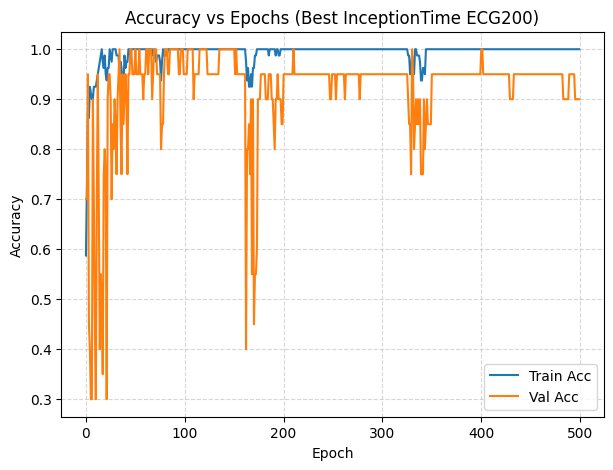

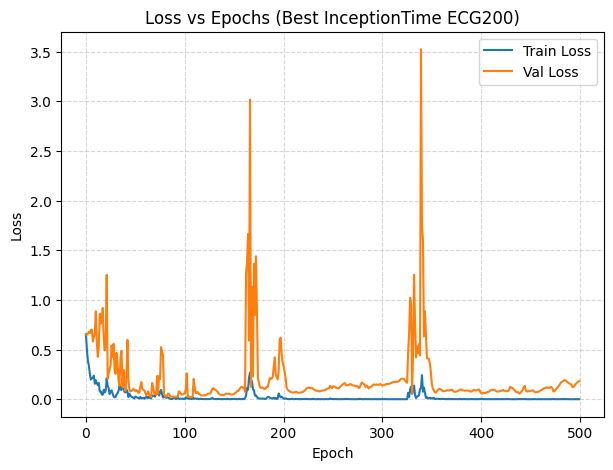

In [ ]:

# Adding seed for reproducability
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
tf.keras.utils.set_random_seed(SEED)

# Required preprocessings for the dataset
def sktime_nested_to_3d(X_nested):
    n_samples, n_channels = X_nested.shape
    L = len(X_nested.iloc[0, 0])
    out = np.empty((n_samples, L, n_channels), dtype=np.float32)
    for i in range(n_samples):
        for c in range(n_channels):
            out[i, :, c] = np.asarray(X_nested.iat[i, c], dtype=np.float32)
    return out

def z_score_per_sample(X):
    m = X.mean(axis=1, keepdims=True)
    s = X.std(axis=1, keepdims=True)
    s = np.where(s == 0, 1.0, s)
    return (X - m) / s

def make_ds(X, y, batch, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=min(len(X), 8192), seed=SEED)
    return ds.batch(batch).prefetch(tf.data.AUTOTUNE)


# Function to plot accuracy/loss curves
def plot_training_curves_inline(history, title_suffix=""):
    h = history.history
    h_acc = h.get('accuracy'); h_val_acc = h.get('val_accuracy')
    h_loss = h.get('loss'); h_val_loss = h.get('val_loss')
    if h_acc is not None and h_val_acc is not None:
        plt.figure(figsize=(7,5))
        plt.plot(h_acc, label='Train Acc'); plt.plot(h_val_acc, label='Val Acc')
        plt.xlabel('Epoch'); plt.ylabel('Accuracy')
        plt.title(f'Accuracy vs Epochs {title_suffix}')
        plt.legend(); plt.grid(True, ls='--', alpha=0.5); plt.show()
    if h_loss is not None and h_val_loss is not None:
        plt.figure(figsize=(7,5))
        plt.plot(h_loss, label='Train Loss'); plt.plot(h_val_loss, label='Val Loss')
        plt.xlabel('Epoch'); plt.ylabel('Loss')
        plt.title(f'Loss vs Epochs {title_suffix}')
        plt.legend(); plt.grid(True, ls='--', alpha=0.5); plt.show()

# Implementing Inception Time Model
def inception_module(x, nb_filters=16, kernel_size=40, bottleneck_size=32):
    if bottleneck_size > 0:
        xi = layers.Conv1D(bottleneck_size, 1, padding='same', use_bias=False)(x)
        xi = layers.BatchNormalization()(xi)
        xi = layers.Activation('relu')(xi)
    else:
        xi = x

    k1 = max(3, min(kernel_size, seq_len))
    k2 = max(3, min(kernel_size // 2, seq_len))
    k3 = max(3, min(kernel_size // 4, seq_len))

    c1 = layers.Conv1D(nb_filters, k1, padding='same', use_bias=False)(xi)
    c2 = layers.Conv1D(nb_filters, k2, padding='same', use_bias=False)(xi)
    c3 = layers.Conv1D(nb_filters, k3, padding='same', use_bias=False)(xi)

    p = layers.MaxPool1D(pool_size=3, strides=1, padding='same')(xi)
    p = layers.Conv1D(nb_filters, 1, padding='same', use_bias=False)(p)

    out = layers.Concatenate(axis=2)([c1, c2, c3, p])
    out = layers.BatchNormalization()(out)
    return layers.Activation('relu')(out)

def shortcut_layer(x, y):
    sc = layers.Conv1D(int(y.shape[-1]), 1, padding='same', use_bias=False)(x)
    sc = layers.BatchNormalization()(sc)
    return layers.Activation('relu')(layers.Add()([sc, y]))

def build_inceptiontime(seq_len, n_channels, depth=3, nb_filters=16, bottleneck_size=32, kernel_size=40):
    inp = layers.Input(shape=(seq_len, n_channels))
    x = inp
    for d in range(depth):
        y = inception_module(x, nb_filters, kernel_size, bottleneck_size)
        x = shortcut_layer(x, y) if d % 3 == 2 else y
    x = layers.GlobalAveragePooling1D()(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    return keras.Model(inp, out)


X_train_arr = sktime_nested_to_3d(X_train)
X_test_arr = sktime_nested_to_3d(X_test)

X_train_norm = z_score_per_sample(X_train_arr)
X_test_norm  = z_score_per_sample(X_test_arr)
del X_train_arr, X_test_arr; gc.collect()

seq_len, n_channels = X_train_norm.shape[1:]

le = LabelEncoder()
y_train_idx = le.fit_transform(np.asarray(y_train))
y_test_idx  = le.transform(np.asarray(y_test))

y_train_arr = y_train_idx.astype("float32").reshape(-1, 1)
y_test_arr  = y_test_idx.astype("float32").reshape(-1, 1)


# Applying stratified split and class weights
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
(train_idx, val_idx), = strat_split.split(X_train_norm, y_train_arr.ravel())
X_tr, y_tr = X_train_norm[train_idx], y_train_arr[train_idx]
X_val, y_val = X_train_norm[val_idx], y_train_arr[val_idx]

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_idx), y=y_train_idx)
class_weight_dict = {i: w for i, w in enumerate(class_weights)}

# Applying grid search for hyperparameter tuning
IT_ARCH = dict(depth=3, nb_filters=16, bottleneck_size=32, kernel_size=40)
epochs_list = [100, 500, 1000]
lr_list     = [0.01, 0.001, 0.1]
batch_list  = [8, 16, 32]

best_f1 = -1.0
best_probs = None
best_info = {}
best_history = None

run = 0
for epochs, lr, batch in itertools.product(epochs_list, lr_list, batch_list):
    run += 1
    keras.backend.clear_session()
    model = build_inceptiontime(seq_len, n_channels, **IT_ARCH)
    model.compile(optimizer=Adam(lr), loss='binary_crossentropy', metrics=['accuracy'])

    train_ds = make_ds(X_tr, y_tr, batch, shuffle=True)
    val_ds   = make_ds(X_val, y_val, batch)



    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=0, class_weight=class_weight_dict)

    test_ds = tf.data.Dataset.from_tensor_slices(X_test_norm).batch(batch)
    y_prob = model.predict(test_ds, verbose=0).ravel()
    y_pred = (y_prob >= 0.5).astype(int)
    y_true = y_test_arr.ravel()

    it_acc  = accuracy_score(y_true, y_pred)
    it_prec = precision_score(y_true, y_pred, zero_division=0)
    it_rec  = recall_score(y_true, y_pred, zero_division=0)
    it_f1   = f1_score(y_true, y_pred, zero_division=0)

    print(f"Run {run:02d} | E={epochs:<4} LR={lr:<.4g} B={batch:<2} -> "
          f"Acc={it_acc:.4f}  P={it_prec:.4f}  R={it_rec:.4f}  F1={it_f1:.4f}")
    if it_f1 > best_f1:
        best_f1 = it_f1
        best_probs = y_prob.copy()
        best_info = {
            "Run": run, "Epochs": epochs, "LR": lr, "Batch": batch,
            "F1": round(it_f1, 4), "Accuracy": round(it_acc, 4)
        }
        best_history = history

    del model, train_ds, val_ds, test_ds
    keras.backend.clear_session()
    gc.collect()

# Saving prob of the best model
np.save("y_prob_ecg_incep.npy", best_probs)

# Best Run info
print("\nBest Run (by F1):")
print(best_info)

if best_history is not None:
    plot_training_curves_inline(best_history, title_suffix="(Best InceptionTime ECG200)")


#**Overlay PR curve for 1D CNN, Transformer and Inception Time**

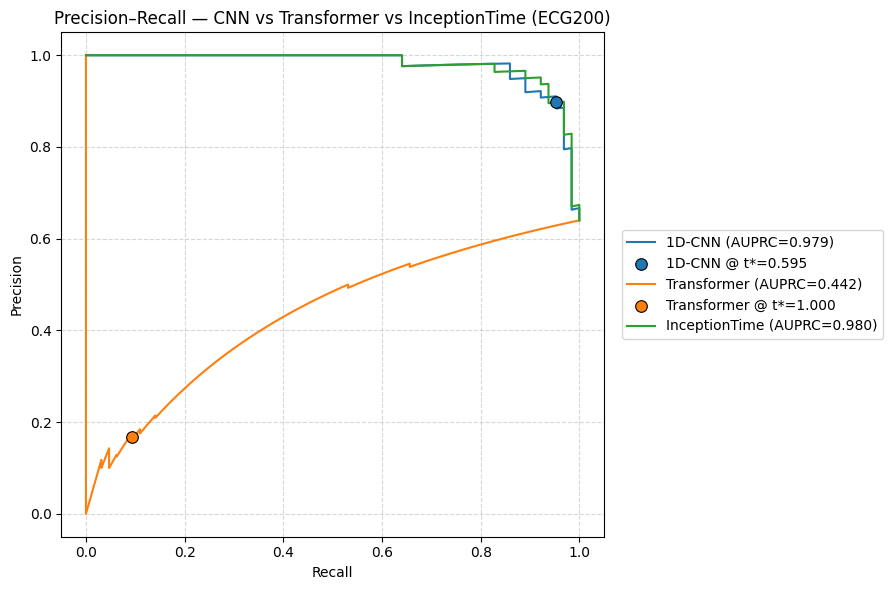

In [ ]:
# Overlay PR curve for CNN, Transformer, InceptionTime (Binary)

def plot_pr_overlay_binary(
    y_true_pos,
    scores_dict,
    thresh_dict=None,
    title="Precision–Recall — 3 Model Comparison (ECG200)",
    loc="lower left"
):
    y_true_pos = np.asarray(y_true_pos).astype(int).ravel()

    plt.figure(figsize=(8,6))
    for name, scores in scores_dict.items():
        scores = np.asarray(scores).ravel()
        precision, recall, thresholds = precision_recall_curve(y_true_pos, scores)
        ap = average_precision_score(y_true_pos, scores)

        # PR curve
        plt.plot(recall, precision, label=f"{name} (AUPRC={ap:.3f})")

        # Mark the best F1 threshold if available
        if thresh_dict is not None and name in thresh_dict and thresholds.size > 0:
            t_star = float(thresh_dict[name])
            idx_star = int(np.argmin(np.abs(thresholds - t_star)))
            p_star = precision[:-1][idx_star]
            r_star = recall[:-1][idx_star]
            plt.scatter(
                r_star, p_star, s=70, marker='o',
                zorder=5, edgecolors='k', linewidths=0.8,
                label=f"{name} @ t*={t_star:.3f}"
            )

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.tight_layout(rect=(0, 0, 0.78, 1.0))
    plt.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=True)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

# Loading saved prediction probabilities & labels
y_true_pos = np.load("y_true_ecg.npy").astype(int)
scores = {
    "1D-CNN":        np.load("y_prob_ecg_cnn.npy"),
    "Transformer":   np.load("y_prob_ecg_trans.npy"),
    "InceptionTime": np.load("y_prob_ecg_incep.npy")
}

thresh_dict = {}

def try_load_thresh(json_path, model_name):
    if os.path.exists(json_path):
        with open(json_path) as f:
            data = json.load(f)
        if "Thresh" in data:
            thresh_dict[model_name] = data["Thresh"]

try_load_thresh("best_ecg200_cnn_meta.json", "1D-CNN")
try_load_thresh("saved_models/best_ecg200_transformer_meta.json", "Transformer")

# Plotting overlay PR curve
plot_pr_overlay_binary(
    y_true_pos=y_true_pos,
    scores_dict=scores,
    thresh_dict=thresh_dict,
    title="Precision–Recall — CNN vs Transformer vs InceptionTime (ECG200)"
)
